# Problem 4

In [270]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
from torch.utils.data import random_split, TensorDataset, DataLoader
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [199]:
import wandb
wandb.login()

wandb: Currently logged in as: vineeth-bhat. Use `wandb login --relogin` to force relogin


True

In [325]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

In [326]:
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

In [327]:
type(train_dataset)

torchvision.datasets.mnist.MNIST

## 4.1 Data visualization and Preprocessing

### Draw a graph that shows the distribution of...

In [180]:
labels = [label for _, label in train_dataset]

In [181]:
unique_labels, label_counts = np.unique(labels, return_counts=True)

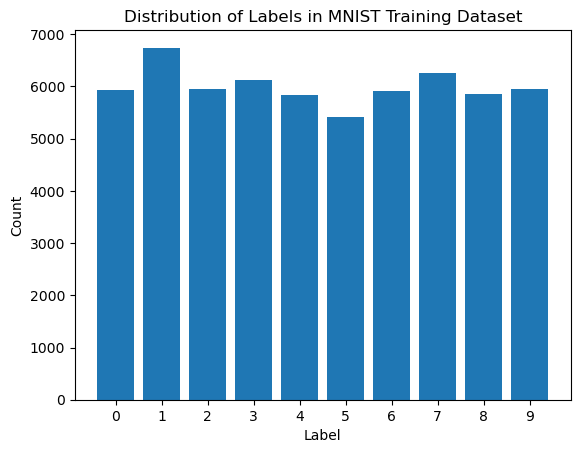

In [182]:
plt.bar(unique_labels, label_counts, tick_label=unique_labels)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in MNIST Training Dataset')

plt.show()

### Visualize several samples (say 5)

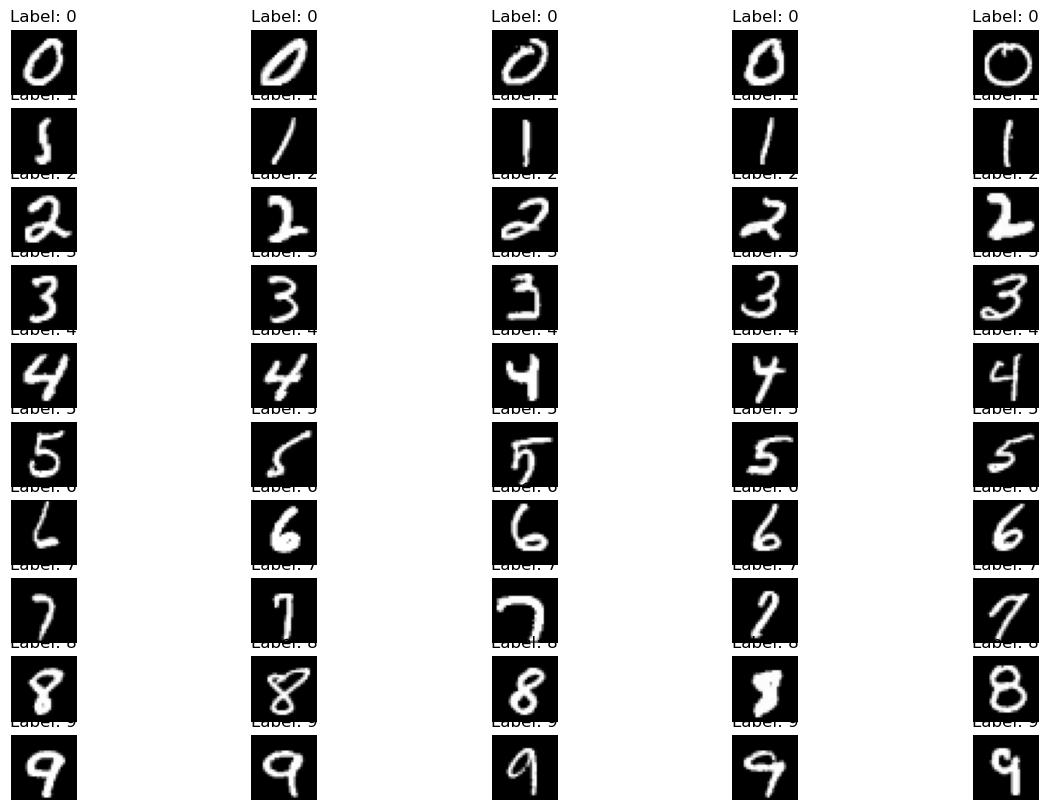

In [183]:
import random
import numpy as np

# Asked chatGPT the "Visualize several samples (say 5) of images from each class."
def show_samples_per_class(dataset, num_samples=5):
    plt.figure(figsize=(15, 10))
    classes = dataset.classes
    for i, class_name in enumerate(classes):
        class_indices = [index for index, label in enumerate(labels) if label == i]
        for j in range(num_samples):
            plt.subplot(10, num_samples, i * num_samples + j + 1)
            sample_index = random.choice(class_indices)
            sample_image, sample_label = dataset[sample_index]
            plt.imshow(np.squeeze(sample_image), cmap='gray')
            plt.title(f'Label: {sample_label}')
            plt.axis('off')

show_samples_per_class(train_dataset)

### Check for any class imbalance and report

       As we can see from this counter as well as the following bar chart there exists a slight imbalance.

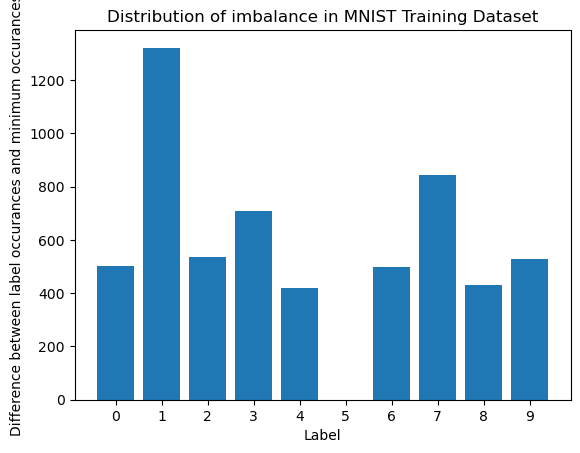

In [11]:
min_label_occurances = np.min(label_counts)
plt.bar(unique_labels, label_counts - min_label_occurances, tick_label=unique_labels)

plt.ylabel('Difference between label occurances and minimum occurances')
plt.xlabel('Label')
plt.title('Distribution of imbalance in MNIST Training Dataset')

plt.show()

### Partition the dataset into train, validation, and test sets.

In [328]:
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

In [329]:
len(train_dataset), len(val_dataset), len(test_dataset)

(48000, 12000, 10000)

In [343]:
len(train_dataset[0])

2

### Write a function to visualize the feature maps. 

In [196]:
# Asked GPT "How can I get intermediate activations in  a CNN and plot them"
def display_feature_maps(model, data_loader, class_id):
    model.eval()

    conv1 = model.conv1
    conv2 = model.conv2

    image = None
    label = None
    for images, labels in data_loader:
        for i in range(len(labels)):
            if labels[i] == class_id:
                image = images[i]
                label = labels[i]
                break
        if image is not None:
            break
            
    # Forward pass to get feature maps
    feature_maps1 = conv1(image.unsqueeze(0))
    feature_maps2 = conv2(feature_maps1)

    # Visualize the feature maps
    num_feature_maps1 = feature_maps1.size(1)
    num_feature_maps2 = feature_maps2.size(1)

    plt.figure(figsize=(12, 4))
            
    for i in range(num_feature_maps1):
        plt.subplot(2, num_feature_maps1, i + 1)
        plt.imshow(feature_maps1[0, i].detach().numpy(), cmap='viridis')
        plt.axis('off')

    for i in range(num_feature_maps2):
        plt.subplot(2, num_feature_maps2, num_feature_maps1 + i + 1)
        plt.imshow(feature_maps2[0, i].detach().numpy(), cmap='viridis')
        plt.axis('off')

    plt.suptitle(f'Feature Maps for Class {label}')
    plt.show()

    feature_maps1 = conv1(image.unsqueeze(0))
    feature_maps2 = conv2(feature_maps1)

## 4.2 Model Building 

In [210]:
# Asked ChatGPT the exact prompt given in question and built upon it
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(32 * 5 * 5, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x

In [211]:
def train(model, train_loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = [] 
    predicted_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # Collect true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

    return running_loss / len(train_loader), 100 * correct / total, true_labels, predicted_labels


In [212]:
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect true and predicted labels
            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    return running_loss / len(val_loader), 100 * correct / total, true_labels, predicted_labels

In [213]:
# hyperparameter
batch_size = 100 # batched for faster results
num_epochs = 5
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 3, 
                 stride = 1, 
                 padding = 0,
                 dropout_rate = 0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))

Epoch: 1
	 train_loss: 1.6774730730056762, 
	 train_acc: 79.79833333333333, 
	 val_loss: 1.515900868177414, 
	 val_acc: 95.11666666666666
Epoch: 2
	 train_loss: 1.522786716222763, 
	 train_acc: 94.35333333333334, 
	 val_loss: 1.497080472111702, 
	 val_acc: 96.66666666666667
Epoch: 3
	 train_loss: 1.5105840839942297, 
	 train_acc: 95.33166666666666, 
	 val_loss: 1.4920598655939101, 
	 val_acc: 97.1
Epoch: 4
	 train_loss: 1.5043507899840673, 
	 train_acc: 95.88833333333334, 
	 val_loss: 1.4875736256440482, 
	 val_acc: 97.54166666666667
Epoch: 5
	 train_loss: 1.5010799904664358, 
	 train_acc: 96.18333333333334, 
	 val_loss: 1.4860949685176215, 
	 val_acc: 97.61666666666666


### Display feature maps after applying convolution and pooling layers for any one class and provide a brief analysis.

/tmp/ipykernel_11417/2596786326.py:35: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(2, num_feature_maps2, num_feature_maps1 + i + 1)


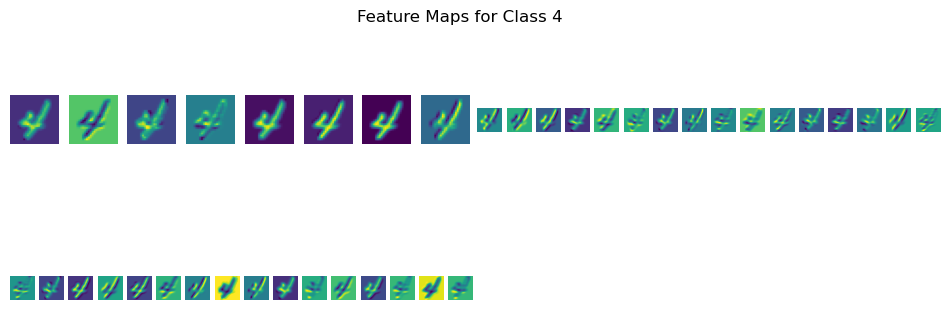

In [197]:
display_feature_maps(model, train_loader, 4)

#### Analysis

- The second conv layer captures more abstract features - there seems to be particular depth around the image
- both the layers depict the boundary between the digit and the surroundings quite well
- the first conv layer captures more edge or line specific features as there exists a sharp difference between adjacent picel colours seems to be at the boundary of the digit unlike the 2nd layer which has a nice gradient over the surface of the digit
- We can also see how the surface area of the digit sort of starts accumulating characterics from its neighbours due to pooling the first layer

## 4.3 Hyperparameter Tuning and Evaluation

In [221]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(32 * 5 * 5, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 100 # batched for faster results
num_epochs = 10
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 3, 
                 stride = 1, 
                 padding = 0,
                 dropout_rate = 0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 100,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 3, 
        'stride': 1, 
        'padding': 0,
        'dropout_rate': 0.5
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
train_acc,94.38833
train_loss,1.52154
val_acc,96.45
val_loss,1.50025


Epoch: 1
	 train_loss: 1.6796695083379745, 
	 train_acc: 79.47166666666666, 
	 val_loss: 1.5159128109614055, 
	 val_acc: 95.21666666666667
Epoch: 2
	 train_loss: 1.5251653403043748, 
	 train_acc: 94.09333333333333, 
	 val_loss: 1.498602357506752, 
	 val_acc: 96.59166666666667
Epoch: 3
	 train_loss: 1.5106961210568746, 
	 train_acc: 95.35, 
	 val_loss: 1.493001573284467, 
	 val_acc: 97.00833333333334
Epoch: 4
	 train_loss: 1.504046834508578, 
	 train_acc: 95.925, 
	 val_loss: 1.4885265489419301, 
	 val_acc: 97.39166666666667
Epoch: 5
	 train_loss: 1.5002330098549526, 
	 train_acc: 96.26333333333334, 
	 val_loss: 1.485384683807691, 
	 val_acc: 97.68333333333334
Epoch: 6
	 train_loss: 1.497507719596227, 
	 train_acc: 96.51166666666667, 
	 val_loss: 1.4833339780569077, 
	 val_acc: 97.88333333333334
Epoch: 7
	 train_loss: 1.4939497937758763, 
	 train_acc: 96.83166666666666, 
	 val_loss: 1.4813520044088364, 
	 val_acc: 98.05833333333334
Epoch: 8
	 train_loss: 1.4931897284587223, 
	 train_acc

train_acc,▁▇▇███████
train_loss,█▂▂▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇████
val_loss,█▅▄▃▂▂▁▁▁▁
train_acc,97.03333
train_loss,1.49149
val_acc,98.13333
val_loss,1.4805


In [223]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(32 * 5 * 5, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 100 # batched for faster results
num_epochs = 10
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 3, 
                 stride = 1, 
                 padding = 0,
                 dropout_rate = 0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 100,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 3, 
        'stride': 1, 
        'padding': 0,
        'dropout_rate': 0
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

train_acc,▁█
train_loss,█▁
val_acc,▁█
val_loss,█▁
train_acc,87.75333
train_loss,1.5857
val_acc,88.225
val_loss,1.58049


Epoch: 1
	 train_loss: 1.669292266368866, 
	 train_acc: 80.41166666666666, 
	 val_loss: 1.5935632129510244, 
	 val_acc: 87.11666666666666


/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Epoch: 2
	 train_loss: 1.585327457388242, 
	 train_acc: 87.82, 
	 val_loss: 1.58028547167778, 
	 val_acc: 88.19166666666666


/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vineeth/miniconda3/envs/smai/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

Epoch: 3
	 train_loss: 1.5741672464211782, 
	 train_acc: 88.84166666666667, 
	 val_loss: 1.5154463281234105, 
	 val_acc: 94.93333333333334
Epoch: 4
	 train_loss: 1.488951993981997, 
	 train_acc: 97.48, 
	 val_loss: 1.4838655173778534, 
	 val_acc: 97.98333333333333
Epoch: 5
	 train_loss: 1.4834101249774296, 
	 train_acc: 97.95, 
	 val_loss: 1.482585941751798, 
	 val_acc: 98.0
Epoch: 6
	 train_loss: 1.4801854121685027, 
	 train_acc: 98.22666666666667, 
	 val_loss: 1.4766954133907955, 
	 val_acc: 98.65833333333333
Epoch: 7
	 train_loss: 1.478598799308141, 
	 train_acc: 98.38166666666666, 
	 val_loss: 1.4774998774131138, 
	 val_acc: 98.55
Epoch: 8
	 train_loss: 1.4767518266042075, 
	 train_acc: 98.55833333333334, 
	 val_loss: 1.4747663338979085, 
	 val_acc: 98.725
Epoch: 9
	 train_loss: 1.4754486779371898, 
	 train_acc: 98.68, 
	 val_loss: 1.474128657579422, 
	 val_acc: 98.78333333333333
Epoch: 10
	 train_loss: 1.4741946413119633, 
	 train_acc: 98.80666666666667, 
	 val_loss: 1.47335784931

train_acc,▁▄▄▇██████
train_loss,█▅▅▂▁▁▁▁▁▁
val_acc,▁▂▆▇▇█████
val_loss,█▇▃▂▂▁▁▁▁▁
train_acc,98.80667
train_loss,1.47419
val_acc,98.85833
val_loss,1.47336


In [226]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(512, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 100 # batched for faster results
num_epochs = 10
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 5, 
                 stride = 1, 
                 padding = 0,
                 dropout_rate = 0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 100,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 5, 
        'stride': 1, 
        'padding': 0,
        'dropout_rate': 0.5
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

Epoch: 1
	 train_loss: 1.6183425738414128, 
	 train_acc: 85.63666666666667, 
	 val_loss: 1.5039904485146205, 
	 val_acc: 95.99166666666666
Epoch: 2
	 train_loss: 1.5169686142603556, 
	 train_acc: 94.77833333333334, 
	 val_loss: 1.492296862602234, 
	 val_acc: 97.10833333333333
Epoch: 3
	 train_loss: 1.5052522246042888, 
	 train_acc: 95.84666666666666, 
	 val_loss: 1.4855152686436972, 
	 val_acc: 97.73333333333333
Epoch: 4
	 train_loss: 1.498727865020434, 
	 train_acc: 96.43, 
	 val_loss: 1.4824357847372691, 
	 val_acc: 97.96666666666667
Epoch: 5
	 train_loss: 1.4953791133562724, 
	 train_acc: 96.73166666666667, 
	 val_loss: 1.4790733138720193, 
	 val_acc: 98.26666666666667
Epoch: 6
	 train_loss: 1.4923846956094107, 
	 train_acc: 97.00666666666666, 
	 val_loss: 1.4772733887036642, 
	 val_acc: 98.51666666666667
Epoch: 7
	 train_loss: 1.4895412079493204, 
	 train_acc: 97.29166666666667, 
	 val_loss: 1.4796410501003265, 
	 val_acc: 98.18333333333334
Epoch: 8
	 train_loss: 1.4893519127368926

train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇███
val_loss,█▅▄▃▂▂▂▁▁▁
train_acc,97.62167
train_loss,1.48574
val_acc,98.725
val_loss,1.47444


In [229]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(32, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 100 # batched for faster results
num_epochs = 5
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 4, 
                 stride = 2, 
                 padding = 0,
                 dropout_rate = 0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 100,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 4, 
        'stride': 3, 
        'padding': 0,
        'dropout_rate': 0.25
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

Epoch: 1
	 train_loss: 1.8128442412614822, 
	 train_acc: 68.58166666666666, 
	 val_loss: 1.5953677455584208, 
	 val_acc: 88.38333333333334
Epoch: 2
	 train_loss: 1.6060808058579763, 
	 train_acc: 87.05333333333333, 
	 val_loss: 1.5359659810860953, 
	 val_acc: 93.51666666666667
Epoch: 3
	 train_loss: 1.5708715230226518, 
	 train_acc: 90.095, 
	 val_loss: 1.5228938639163971, 
	 val_acc: 94.275
Epoch: 4
	 train_loss: 1.556891038417816, 
	 train_acc: 91.22666666666667, 
	 val_loss: 1.5159084359804789, 
	 val_acc: 95.00833333333334
Epoch: 5
	 train_loss: 1.5480652807156245, 
	 train_acc: 91.99, 
	 val_loss: 1.5102604279915492, 
	 val_acc: 95.43333333333334


train_acc,▁▇▇██
train_loss,█▃▂▁▁
val_acc,▁▆▇██
val_loss,█▃▂▁▁
train_acc,91.99
train_loss,1.54807
val_acc,95.43333
val_loss,1.51026


In [232]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(1568, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 70 # batched for faster results
num_epochs = 15
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 5, 
                 stride = 1, 
                 padding = 2,
                 dropout_rate = 0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 70,
        'num_epochs': 15,
        'learning_rate': 0.001,
        'kernel_size': 5, 
        'stride': 1, 
        'padding': 2,
        'dropout_rate': 0.25
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

Epoch: 1
	 train_loss: 1.5594013109629528, 
	 train_acc: 91.01166666666667, 
	 val_loss: 1.4955389832341395, 
	 val_acc: 96.79166666666667
Epoch: 2
	 train_loss: 1.492133303122087, 
	 train_acc: 97.105, 
	 val_loss: 1.4838173528050267, 
	 val_acc: 97.8
Epoch: 3
	 train_loss: 1.4849373211949577, 
	 train_acc: 97.75333333333333, 
	 val_loss: 1.4780455418797427, 
	 val_acc: 98.35
Epoch: 4
	 train_loss: 1.4814910999822728, 
	 train_acc: 98.08833333333334, 
	 val_loss: 1.4751612017321032, 
	 val_acc: 98.7
Epoch: 5
	 train_loss: 1.4789080359996893, 
	 train_acc: 98.295, 
	 val_loss: 1.4730194245660029, 
	 val_acc: 98.90833333333333
Epoch: 6
	 train_loss: 1.4767054759816969, 
	 train_acc: 98.53666666666666, 
	 val_loss: 1.4724446022233297, 
	 val_acc: 98.925
Epoch: 7
	 train_loss: 1.4756928997717815, 
	 train_acc: 98.59166666666667, 
	 val_loss: 1.4725176220716432, 
	 val_acc: 98.9
Epoch: 8
	 train_loss: 1.4749166765413084, 
	 train_acc: 98.63333333333334, 
	 val_loss: 1.4711986364320266, 
	 

train_acc,▁▆▇▇▇██████████
train_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▅▆▇▇▇▇███████
val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
train_acc,99.04
train_loss,1.47089
val_acc,99.4
val_loss,1.46736


In [235]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(32, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 64 # batched for faster results
num_epochs = 10
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 7, 
                 stride = 2, 
                 padding = 2,
                 dropout_rate = 0.75).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 64,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 7, 
        'stride': 2, 
        'padding': 2,
        'dropout_rate': 0.75
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

Epoch: 1
	 train_loss: 1.9436352950677689, 
	 train_acc: 52.13333333333333, 
	 val_loss: 1.5905308970745573, 
	 val_acc: 90.99166666666666
Epoch: 2
	 train_loss: 1.8117037226142152, 
	 train_acc: 65.18666666666667, 
	 val_loss: 1.5295236459437838, 
	 val_acc: 94.21666666666667
Epoch: 3
	 train_loss: 1.7757679057527962, 
	 train_acc: 69.61166666666666, 
	 val_loss: 1.5179408636498959, 
	 val_acc: 94.975
Epoch: 4
	 train_loss: 1.7544812138146684, 
	 train_acc: 71.96833333333333, 
	 val_loss: 1.5116906692372991, 
	 val_acc: 95.375
Epoch: 5
	 train_loss: 1.731043994045461, 
	 train_acc: 74.19333333333333, 
	 val_loss: 1.505462131601699, 
	 val_acc: 95.94166666666666
Epoch: 6
	 train_loss: 1.720174341567798, 
	 train_acc: 75.07, 
	 val_loss: 1.5017502168391614, 
	 val_acc: 96.31666666666666
Epoch: 7
	 train_loss: 1.7075389391069473, 
	 train_acc: 76.215, 
	 val_loss: 1.4996946232115969, 
	 val_acc: 96.375
Epoch: 8
	 train_loss: 1.6973960629658404, 
	 train_acc: 77.16333333333333, 
	 val_los

train_acc,▁▅▆▆▇▇████
train_loss,█▄▃▃▂▂▂▁▁▁
val_acc,▁▅▆▇▇█████
val_loss,█▃▃▂▂▁▁▁▁▁
train_acc,77.90667
train_loss,1.68882
val_acc,96.55833
val_loss,1.49803


In [238]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(32, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 64 # batched for faster results
num_epochs = 10
learning_rate = 0.01

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 6, 
                 stride = 3, 
                 padding = 3,
                 dropout_rate = 0.5).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 64,
        'num_epochs': 10,
        'learning_rate': 0.01,
        'kernel_size': 6, 
        'stride': 2, 
        'padding': 3,
        'dropout_rate': 0.5
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

Epoch: 1
	 train_loss: 1.672169455841406, 
	 train_acc: 79.19666666666667, 
	 val_loss: 1.5227772143292935, 
	 val_acc: 93.84166666666667
Epoch: 2
	 train_loss: 1.6043921693810013, 
	 train_acc: 85.65, 
	 val_loss: 1.5168878150747178, 
	 val_acc: 94.425
Epoch: 3
	 train_loss: 1.5942053911782532, 
	 train_acc: 86.69666666666667, 
	 val_loss: 1.5165768392542576, 
	 val_acc: 94.40833333333333
Epoch: 4
	 train_loss: 1.5798178095299045, 
	 train_acc: 88.08666666666667, 
	 val_loss: 1.5073525081289576, 
	 val_acc: 95.4
Epoch: 5
	 train_loss: 1.584336111159213, 
	 train_acc: 87.63333333333334, 
	 val_loss: 1.5158853378701718, 
	 val_acc: 94.53333333333333
Epoch: 6
	 train_loss: 1.5780222165559146, 
	 train_acc: 88.25, 
	 val_loss: 1.5057239843175767, 
	 val_acc: 95.525
Epoch: 7
	 train_loss: 1.58149168587951, 
	 train_acc: 87.93833333333333, 
	 val_loss: 1.5127545462009755, 
	 val_acc: 94.84166666666667
Epoch: 8
	 train_loss: 1.5796708003290172, 
	 train_acc: 88.11166666666666, 
	 val_loss: 1

train_acc,▁▆▇███████
train_loss,█▃▂▁▁▁▁▁▁▁
val_acc,▁▃▃▇▄█▅█▇▄
val_loss,█▆▅▂▅▁▄▁▂▅
train_acc,87.66
train_loss,1.58426
val_acc,94.45
val_loss,1.51667


In [240]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(800, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 50 # batched for faster results
num_epochs = 10
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 7, 
                 stride = 1, 
                 padding = 2,
                 dropout_rate = 0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 50,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 7, 
        'stride': 1, 
        'padding': 2,
        'dropout_rate': 0.25
    }
)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))
    
    wandb.log({"train_loss": train_loss, "train_acc": train_acc, "val_loss": val_loss, "val_acc": val_acc})

    train_confusion_matrix = confusion_matrix(train_true_labels, train_predicted_labels)
    wandb.log({"train_confusion_matrix": train_confusion_matrix})
    
    train_class_metrics = classification_report(train_true_labels, train_predicted_labels, output_dict=True)
    wandb.log({"train_class_metrics": train_class_metrics})

    val_confusion_matrix = confusion_matrix(val_true_labels, val_predicted_labels)
    wandb.log({"val_confusion_matrix": val_confusion_matrix})
    
    val_class_metrics = classification_report(val_true_labels, val_predicted_labels, output_dict=True)
    wandb.log({"val_class_metrics": val_class_metrics})
    
wandb.finish()

Epoch: 1
	 train_loss: 1.5474971862634024, 
	 train_acc: 92.14, 
	 val_loss: 1.4930729086200396, 
	 val_acc: 96.975
Epoch: 2
	 train_loss: 1.4916593539714813, 
	 train_acc: 97.115, 
	 val_loss: 1.4811227589845657, 
	 val_acc: 98.05833333333334
Epoch: 3
	 train_loss: 1.483900612394015, 
	 train_acc: 97.82, 
	 val_loss: 1.4777215048670769, 
	 val_acc: 98.36666666666666
Epoch: 4
	 train_loss: 1.480106764336427, 
	 train_acc: 98.18166666666667, 
	 val_loss: 1.4727391247948012, 
	 val_acc: 98.90833333333333
Epoch: 5
	 train_loss: 1.4782538974285127, 
	 train_acc: 98.32333333333334, 
	 val_loss: 1.4729986662666004, 
	 val_acc: 98.81666666666666
Epoch: 6
	 train_loss: 1.476500370601813, 
	 train_acc: 98.49166666666666, 
	 val_loss: 1.4727286040782928, 
	 val_acc: 98.89166666666667
Epoch: 7
	 train_loss: 1.4755672160784403, 
	 train_acc: 98.565, 
	 val_loss: 1.4712490568558374, 
	 val_acc: 99.05
Epoch: 8
	 train_loss: 1.474681425789992, 
	 train_acc: 98.685, 
	 val_loss: 1.4677354802687963, 
	

train_acc,▁▆▇▇▇█████
train_loss,█▃▂▂▂▁▁▁▁▁
val_acc,▁▄▅▇▆▇▇██▇
val_loss,█▅▄▂▂▂▂▁▁▂
train_acc,98.86167
train_loss,1.47257
val_acc,99.16667
val_loss,1.46962


### Compare the effect of using and not using dropout layers.

- faster execution since there are less samples to deal with
- less overfitting on using dropout
- using drop out takes more number of epochs for same results as no dropout

### Other observations
        In report
        
#### Best results
```
wandb.init(
    project="smai-A3-problem-4-CNN",
    
    config={
        'batch_size': 50,
        'num_epochs': 10,
        'learning_rate': 0.001,
        'kernel_size': 7, 
        'stride': 1, 
        'padding': 2,
        'dropout_rate': 0.25
    }
)

```

## 4.4 Model Evaluation and Analysis

In [241]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(800, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 50 # batched for faster results
num_epochs = 10
learning_rate = 0.001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 7, 
                 stride = 1, 
                 padding = 2,
                 dropout_rate = 0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))

Epoch: 1
	 train_loss: 1.5726437469323475, 
	 train_acc: 89.42333333333333, 
	 val_loss: 1.4883559549848238, 
	 val_acc: 97.6
Epoch: 2
	 train_loss: 1.4904970721403759, 
	 train_acc: 97.23666666666666, 
	 val_loss: 1.4796765247980754, 
	 val_acc: 98.25833333333334
Epoch: 3
	 train_loss: 1.482917460401853, 
	 train_acc: 97.90333333333334, 
	 val_loss: 1.476945578555266, 
	 val_acc: 98.45833333333333
Epoch: 4
	 train_loss: 1.4793120104074478, 
	 train_acc: 98.24833333333333, 
	 val_loss: 1.4746174469590188, 
	 val_acc: 98.675
Epoch: 5
	 train_loss: 1.47773997426033, 
	 train_acc: 98.405, 
	 val_loss: 1.4753808856010437, 
	 val_acc: 98.58333333333333
Epoch: 6
	 train_loss: 1.4758418779571851, 
	 train_acc: 98.575, 
	 val_loss: 1.472016083697478, 
	 val_acc: 98.96666666666667
Epoch: 7
	 train_loss: 1.4747849588592847, 
	 train_acc: 98.67333333333333, 
	 val_loss: 1.4704943264524142, 
	 val_acc: 99.06666666666666
Epoch: 8
	 train_loss: 1.4742517970999083, 
	 train_acc: 98.7, 
	 val_loss: 1.

In [242]:
model

CNNModel(
  (conv1): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (relu): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=800, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [243]:
model.eval()

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

true_labels, predicted_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


### Evaluate your best model on the test set and report accuracy, per-class accuracy, and classification report.

In [247]:
accuracy = accuracy_score(true_labels, predicted_labels)
print("\t Total accuracy on test data is", accuracy)

	 Total accuracy on test data is 0.9879


In [249]:
class_report = classification_report(true_labels, predicted_labels)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.98      0.99      1032
           3       0.96      1.00      0.98      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.98       892
           6       1.00      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.98      0.99       974
           9       1.00      0.98      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



### Provide a clear visualization of the model’s performance

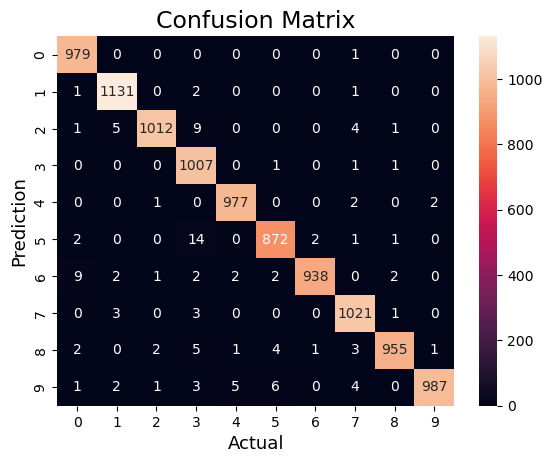

In [251]:
cm = confusion_matrix(true_labels, predicted_labels)
import seaborn as sns

sns.heatmap(cm, 
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

### Identify a few instances where the model makes incorrect predictions and analyze possible reasons behind these misclassifications.

In [252]:
misclassified_samples = []
for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = outputs.max(1)
    for i in range(len(labels)):
        if predicted[i] != labels[i]:
            misclassified_samples.append((images[i], predicted[i], labels[i]))

In [262]:
# sampling only a few
import random

sampled_misclassified_samples = random.sample(misclassified_samples, 6)

In [263]:
len(sampled_misclassified_samples)

6

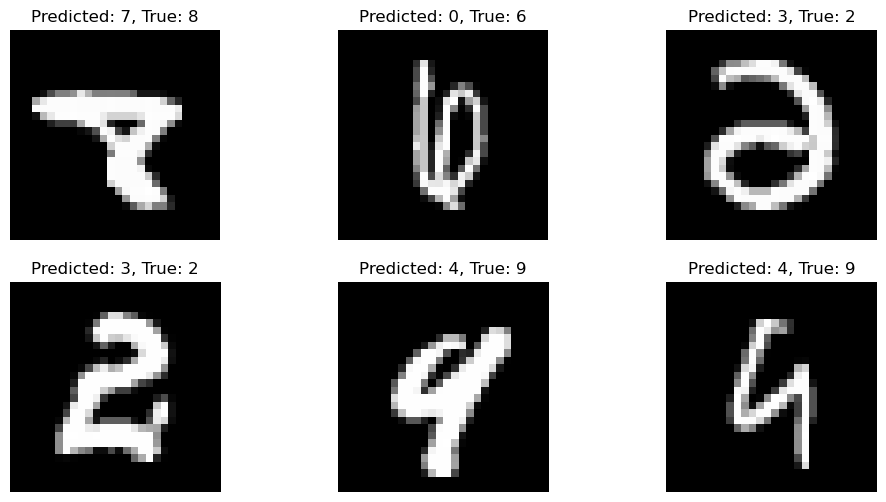

In [264]:
# asked chatGPT - give code to show images in a rows
def show_misclassified_samples(samples):
    plt.figure(figsize=(12, 6))
    for i, (image, predicted, true) in enumerate(samples):
        plt.subplot(2, len(samples) // 2, i + 1)
        plt.imshow(image.cpu().numpy().squeeze(), cmap='gray')
        plt.title(f"Predicted: {predicted}, True: {true}")
        plt.axis('off')
    plt.show()

show_misclassified_samples(sampled_misclassified_samples)


#### Possible reasons

- The handwriting in most of these are highly ambiguous and can be taken as something else
- A few samples that should have been classified as 9 are classified as 4 because the digits are incomplete (lack strokes)
- Moreover, 28x28 is a very low image resolution and can lead to ambiguity

## 4.5 Train on Noisy Dataset

In [344]:
import scipy.io

noisy_data = scipy.io.loadmat('./mnist-with-awgn.mat')

noisy_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Sun Nov 16 16:53:32 2014',
 '__version__': '1.0',
 '__globals__': [],
 'train_x': array([[  0,   0,  11, ...,  59,   2,  91],
        [  0,  41,   0, ...,   0, 106,   0],
        [  0,  23,  71, ...,  36,   0,  67],
        ...,
        [ 38,  36,   0, ...,   0, 119,   0],
        [ 82,   4,   0, ...,   0,   0,  30],
        [  0,   0, 193, ...,  15,   0,  79]], dtype=uint8),
 'test_x': array([[129,   0, 129, ...,   0,  52,   0],
        [  0,  65, 171, ..., 126,   0,   0],
        [  0,  49, 176, ...,   0,  71,   0],
        ...,
        [ 47,  54,   0, ...,  58,   0,   0],
        [  0,   4,   0, ...,   8,   7,  89],
        [  0,  61, 130, ...,   0,   0,  49]], dtype=uint8),
 'train_y': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        ...,
        [1, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 1, ..., 0, 0, 0]], dtype=uint8),
 'test_y

In [354]:
from sklearn.model_selection import train_test_split

train_x = noisy_data['train_x'].reshape(-1, 1, 28, 28)
train_y = np.argmax(noisy_data['train_y'], axis=1)
test_x = noisy_data['test_x'].reshape(-1, 1, 28, 28)
test_y = np.argmax(noisy_data['test_y'], axis=1)

train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

In [355]:
train_x.shape, train_y.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [356]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)
val_dataset = TensorDataset(val_x, val_y)

len(train_dataset), len(test_dataset), len(val_dataset)

(48000, 10000, 12000)

In [362]:
class CNNModel(nn.Module):
    def __init__(self, kernel_size = 3, stride = 1, dropout_rate = 0.5, padding = 0):        
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=kernel_size, stride=stride, padding=padding)
        self.relu = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(2)
        self.dropout = nn.Dropout(p=dropout_rate)
        
        self.fc = nn.Linear(800, 10)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool1(x)
                
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool2(x)
                
        x = self.dropout(x)
        
        x = x.view(x.size(0), -1) 
        # basically flattens based on batch size - torch.Size([100, 32, 5, 5]) to torch.Size([100, 800])
        
        x = self.fc(x)
        
        x = self.softmax(x)
        return x
    
# hyperparameter
batch_size = 100
num_epochs = 10
learning_rate = 0.0001

# model and optimizer init
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNNModel(kernel_size = 7, 
                 stride = 1, 
                 padding = 2,
                 dropout_rate = 0.25).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# defining loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

for epoch in range(num_epochs):
    train_loss, train_acc, train_true_labels, train_predicted_labels = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc, val_true_labels, val_predicted_labels = validate(model, val_loader, criterion, device)
    
    print("Epoch: {}".format(epoch+1))
    print("\t train_loss: {}, \n\t train_acc: {}, \n\t val_loss: {}, \n\t val_acc: {}".format(train_loss, train_acc, val_loss, val_acc))

Epoch: 1
	 train_loss: 2.023150368283192, 
	 train_acc: 43.50416666666667, 
	 val_loss: 1.8210085610548654, 
	 val_acc: 63.833333333333336
Epoch: 2
	 train_loss: 1.8053777148326238, 
	 train_acc: 65.35833333333333, 
	 val_loss: 1.7185321211814881, 
	 val_acc: 74.01666666666667
Epoch: 3
	 train_loss: 1.7263706234594187, 
	 train_acc: 73.3125, 
	 val_loss: 1.7016103674968084, 
	 val_acc: 75.86666666666666
Epoch: 4
	 train_loss: 1.6468548951049646, 
	 train_acc: 81.41875, 
	 val_loss: 1.614822734395663, 
	 val_acc: 84.60833333333333
Epoch: 5
	 train_loss: 1.5850110322237014, 
	 train_acc: 87.5625, 
	 val_loss: 1.5195976396401722, 
	 val_acc: 94.19166666666666
Epoch: 6
	 train_loss: 1.5278358260790508, 
	 train_acc: 93.3625, 
	 val_loss: 1.510629372795423, 
	 val_acc: 94.99166666666666
Epoch: 7
	 train_loss: 1.5190744059781234, 
	 train_acc: 94.27083333333333, 
	 val_loss: 1.5060345967610678, 
	 val_acc: 95.53333333333333
Epoch: 8
	 train_loss: 1.5124843642115593, 
	 train_acc: 94.84791666

#### NOTE

Had to change learning rate due to noisy data.

Else, accuracy was stuck at 9%

### Report validation losses, validation scores, training losses, training scores.
Already done per epoch

### Evaluate your model on test data and print the classification report.

In [363]:
model.eval()

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

true_labels, predicted_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = outputs.max(1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

class_report = classification_report(true_labels, predicted_labels)
print(class_report)

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.98      0.99      0.98      1135
           2       0.96      0.97      0.96      1032
           3       0.98      0.96      0.97      1010
           4       0.97      0.96      0.97       982
           5       0.98      0.97      0.97       892
           6       0.97      0.98      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.97      0.95      0.96       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



## 4.6 AutoEncoders to Save the Day

In [375]:
# Asked chatGPT "Write an autoencoder to denoise mnist data"
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)

def add_noise(data, noise_stddev=0.2):
    noisy_data = data + noise_stddev * torch.randn(data.shape)
    return torch.clamp(noisy_data, 0, 1)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.encoder(x)
        x = self.decoder(x)
        return x

autoencoder = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    for data in train_loader:
        inputs, _ = data
        noisy_inputs = add_noise(inputs)
        
        optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        loss = criterion(outputs, inputs.view(inputs.size(0), -1))
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/10], Loss: 0.0210
Epoch [2/10], Loss: 0.0178
Epoch [3/10], Loss: 0.0167
Epoch [4/10], Loss: 0.0137
Epoch [5/10], Loss: 0.0123
Epoch [6/10], Loss: 0.0116
Epoch [7/10], Loss: 0.0110
Epoch [8/10], Loss: 0.0108
Epoch [9/10], Loss: 0.0088
Epoch [10/10], Loss: 0.0108


### Visualise the classes and feature space before and after de-noising

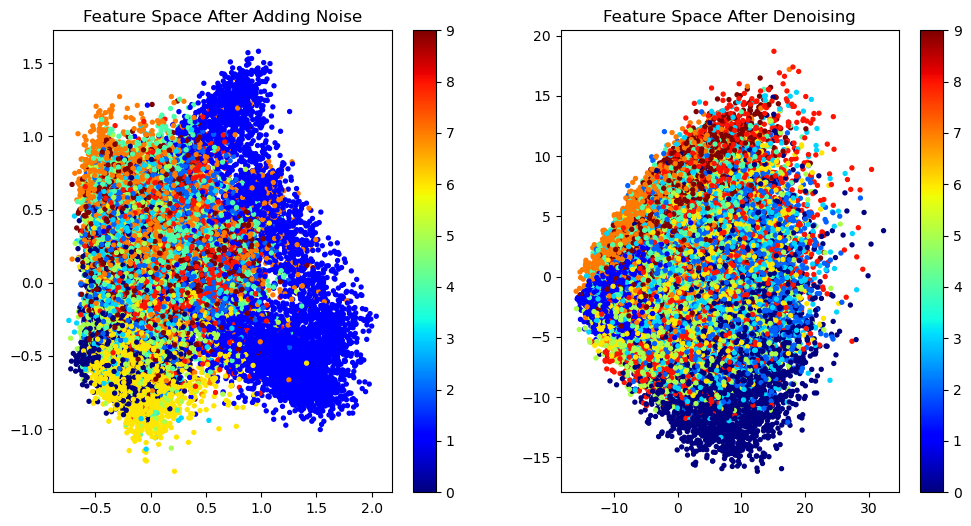

In [376]:
from sklearn.decomposition import PCA

def get_features(model, dataloader):
    features = []
    labels = []
    for data in dataloader:
        inputs, target = data
        features_batch = model.encoder(inputs.view(inputs.size(0), -1))
        features.extend(features_batch.detach().numpy())
        labels.extend(target.numpy())
    return np.array(features), np.array(labels)

features_before, labels = get_features(autoencoder, train_loader)

noisy_features = add_noise(torch.Tensor(features_before), noise_stddev=0.2).numpy()

pca = PCA(n_components=2)

reduced_noisy_features = pca.fit_transform(noisy_features)
reduced_features = pca.fit_transform(features_before)

# Asked chatGPT for code to show two featurespaces in one plot

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(reduced_noisy_features[:, 0], reduced_noisy_features[:, 1], c=labels, cmap=plt.get_cmap('jet'), s=8)
plt.title('Feature Space After Adding Noise')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap=plt.get_cmap('jet'), s=8)
plt.title('Feature Space After Denoising')
plt.colorbar()

plt.show()

### Now using the de-noised dataset, train your best model from the previous parts

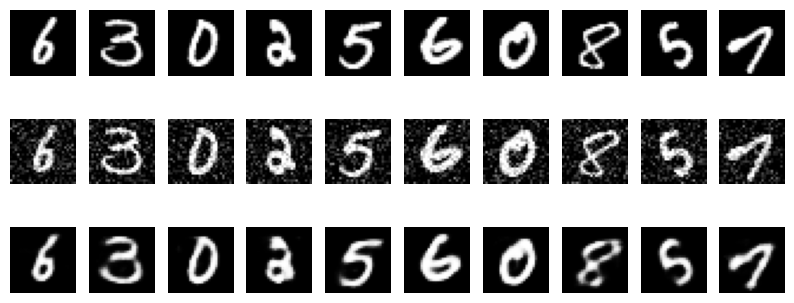

In [383]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

# debug function to see whether it's really denoising 
def visualize_images(original, noisy, denoised):
    original = original.view(10, 28, 28).cpu().detach().numpy()
    noisy = noisy.view(10, 28, 28).cpu().detach().numpy()
    denoised = denoised.view(10, 28, 28).cpu().detach().numpy()

    fig, axes = plt.subplots(3, 10, figsize=(10, 4))
    for i in range(10):
        axes[0, i].imshow(original[i], cmap='gray')
        axes[1, i].imshow(noisy[i], cmap='gray')
        axes[2, i].imshow(denoised[i], cmap='gray')
    for ax in axes.ravel():
        ax.axis('off')
    plt.show()

with torch.no_grad():
    data_iterator = iter(test_loader)
    test_images, test_labels = next(data_iterator)
    noisy_test_images = add_noise(test_images)
    

with torch.no_grad():
    denoised_test_images = autoencoder(noisy_test_images)

visualize_images(test_images, noisy_test_images, denoised_test_images)

In [405]:
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True)
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10, shuffle=True)

denoised_test_images = []
test_labels = []
denoised_train_images = []
train_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        denoised_test_images.extend(autoencoder(add_noise(images)))
        test_labels.extend(labels)
        
    for images, labels in train_loader:
        denoised_train_images.extend(autoencoder(add_noise(images)))
        train_labels.extend(labels)
        
denoised_test_data= np.array(denoised_test_data).reshape(-1, 1, 28, 28)
test_labels = np.array(test_labels)
denoised_train_images =  np.array(denoised_train_images).reshape(-1, 1, 28, 28)
train_labels = np.array(train_labels)

In [408]:
denoised_train_images.shape

(60000,)

In [407]:
train_x, val_x, train_y, val_y = train_test_split(denoised_train_images, train_labels, test_size=0.2, random_state=42)

train_dataset = TensorDataset(train_x, train_y)
val_dataset = TensorDataset(val_x, val_y)

len(train_dataset), len(val_dataset)

TypeError: 'int' object is not callable